In [4]:
!pip install pytreebank
!python -m spacy download en_core_web_md

  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37070 sha256=863b04efe580c5e2fc95e4370dc2a491ec6f28f8eb59f8ca807c4622ef858007
  Stored in directory: /root/.cache/pip/wheels/5b/84/1b/8fbd390149c4c56517bf3cb62bb25d3cf6f5cf575e66710ced
Successfully built pytreebank
     |████████████████████████████████| 96.4 MB 1.1 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=c282a89d36a469d9e028763ad0ca54802c5c32fa89a456653b57a7e435ee2a9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-_4600la8/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [1]:
import spacy # Restart runtime if you get an error "Ctrl + M"
nlp = spacy.load('en_core_web_md')

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import pytreebank
# load the sentiment treebank corpus in the parenthesis format
dataset = pytreebank.load_sst()
# add Javascript and CSS to the Ipython notebook
pytreebank.LabeledTree.inject_visualization_javascript()
# select and example to visualize
example = dataset["train"][4]
# display it in the page
example.display()
print("Text format:")
print(example)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text format:
(3 (2 Yet) (3 (2 (2 the) (2 act) )(3 (4 (3 (2 is) (3 (2 still) (4 charming) ))(2 here) )(2 .) )))


#SENTENCE + TF-IDF

In [2]:
def extract_text_and_label(tree_dataset):
  X = []
  y = []
  for tree in tree_dataset: #discard neutral trees
    if tree.label != 2:
      lab = -1
      if tree.label > 2:
        lab = 1
      X.append(tree.to_lines()[0])
      y.append(lab)
  return X, y

In [3]:
vectorizer_sent = CountVectorizer() 
tftransformer_sent = TfidfTransformer()

X_train_temp, y_train_sent = extract_text_and_label(dataset["train"])

X_train_vec = vectorizer_sent.fit_transform(X_train_temp)
tftransformer_sent.fit(X_train_vec)

X_train_sent = []
for phrase in X_train_temp:
  in_array = [phrase]
  X_train_sent += [tftransformer_sent.transform(vectorizer_sent.transform(in_array)).toarray()[0]]

In [4]:
svc_sent = SVC()
svc_sent.fit(X_train_sent, y_train_sent)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [5]:
X_test_temp, y_test_sent = extract_text_and_label(dataset["test"])
X_test_sent = []
for phrase in X_test_temp:
  in_array = [phrase]
  X_test_sent += [tftransformer_sent.transform(vectorizer_sent.transform(in_array)).toarray()[0]]

In [6]:
y_pred_sent = svc_sent.predict(X_test_sent)

accuracy_score(y_test_sent, y_pred_sent)

0.8061504667764964

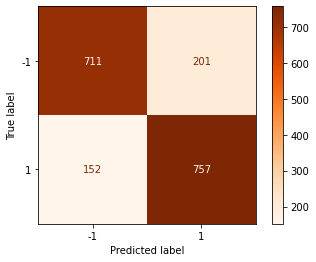

In [7]:
matrix_sent = confusion_matrix(y_test_sent, y_pred_sent, labels = [-1,1])
matrix_display = ConfusionMatrixDisplay(matrix_sent, display_labels=[-1,1])
matrix_display.plot(cmap="Oranges", values_format='') 

#POS + BAG OF WORD + LABEL

In [22]:
posbw_vectorizer = CountVectorizer() 
posbw_collection = []
for tree in dataset["train"]:
  if tree.label != 2:
    doc = nlp(tree.to_lines()[0])
    for word in doc:
      posbw_collection += [word.pos_]
posbw_vectorizer.fit(posbw_collection)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [23]:
def obtain_label_and_posbw(tree_dataset):
  X = []
  y = []
  for tree in tree_dataset:
    if tree.label != 2:
      lab = -1
      if tree.label > 2:
        lab = 1
      doc_tree = nlp(tree.to_lines()[0])
      all_pos = []
      for token in doc_tree:
        all_pos.append(token.pos_)
      pos_part = posbw_vectorizer.transform([' '.join(all_pos)]).toarray()
      label_and_pos = np.append([tree.children[0].label, tree.children[1].label], pos_part)
      X.append(label_and_pos)
      y.append(lab)
  return X, y

In [24]:
X_train_posbw , y_train_posbw = obtain_label_and_posbw(dataset["train"])

In [25]:
svc_posbw = SVC()
svc_posbw.fit(X_train_posbw, y_train_posbw)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
X_test_posbw , y_test_posbw = obtain_label_and_posbw(dataset["test"])

In [27]:
y_pred_posbw = svc_posbw.predict(X_test_posbw)

accuracy_score(y_test_posbw, y_pred_posbw)

0.9132344865458539

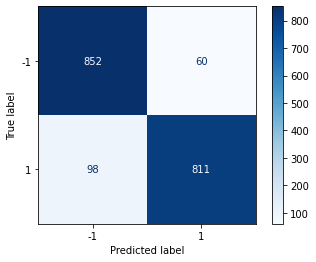

In [28]:
matrix_posbw = confusion_matrix(y_test_posbw, y_pred_posbw, labels = [-1,1])
matrix_display = ConfusionMatrixDisplay(matrix_posbw, display_labels=[-1,1])
matrix_display.plot(cmap="Blues", values_format='')

#POS + TF-IDF + LABEL

In [29]:
postfidf_vectorizer = CountVectorizer() 
postfidf_collection = []
for tree in dataset["train"]:
  if tree.label != 2:
    doc = nlp(tree.to_lines()[0])
    for word in doc:
      postfidf_collection += [word.pos_]
matrix_postfidf = postfidf_vectorizer.fit_transform(postfidf_collection)
transformer_postfidf = TfidfTransformer()
transformer_postfidf.fit(matrix_postfidf)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [30]:
def obtain_label_and_postfidf(tree_dataset):
  X = []
  y = []
  for tree in tree_dataset:
    if tree.label != 2:
      lab = -1
      if tree.label > 2:
        lab = 1
      doc_tree = nlp(tree.to_lines()[0])
      all_pos = []
      for token in doc_tree:
        all_pos.append(token.pos_)      
      pos_part = transformer_postfidf.transform(postfidf_vectorizer.transform([' '.join(all_pos)])).toarray()
      label_and_pos = np.append([tree.children[0].label, tree.children[1].label], pos_part)
      X.append(label_and_pos)
      y.append(lab)
  return X, y

In [31]:
X_train_postfidf , y_train_postfidf = obtain_label_and_postfidf(dataset["train"])

In [32]:
svc_postfidf = SVC()
svc_postfidf.fit(X_train_postfidf, y_train_postfidf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
X_test_postfidf , y_test_postfidf = obtain_label_and_postfidf(dataset["test"])

In [34]:
y_pred_postfidf = svc_postfidf.predict(X_test_postfidf)

accuracy_score(y_test_postfidf, y_pred_postfidf)

0.9242174629324547

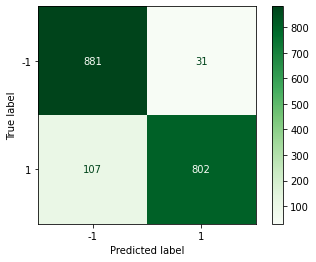

In [35]:
matrix_postfidf = confusion_matrix(y_test_postfidf, y_pred_postfidf, labels = [-1,1])
matrix_display = ConfusionMatrixDisplay(matrix_postfidf, display_labels=[-1,1])
matrix_display.plot(cmap="Greens", values_format='')